In [1]:

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.pipeline import Pipeline
from utils.utilities import bootstrap_all_distance_metrics, gen_feature_dict_lasso
from utils.plots import plot_confidence_interval


In [2]:
pipe = Pipeline([("StandardScaler",StandardScaler()),("Lasso_regressor",LassoCV(max_iter= 10000))])
param_grid = {}
s = bootstrap_all_distance_metrics(pipe, param_grid, n = 10)

number of sample runs: 10
loading in data
running bootstrap
0


/tmp/ipykernel_267930/74185267.py:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  plt.plot((lower,upper),(y,y),'ro-',color='orange')


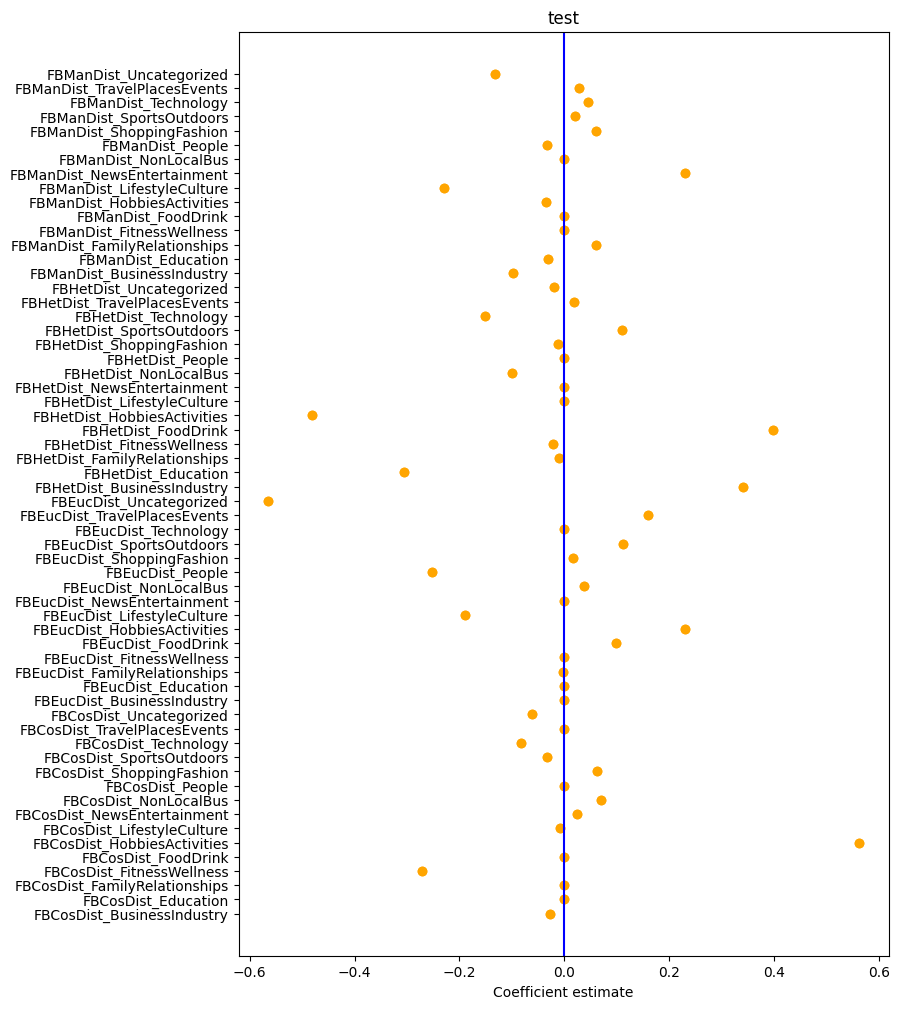

In [8]:
feature_dict = gen_feature_dict_lasso(s, with_dist=True, all_distance= True)
feature_dict = dict( sorted(feature_dict.items(), key=lambda x: x[0].lower()) )
plot_confidence_interval(feature_dict,"test")

In [ ]:
#from src.drivers.train_models.all_distance_metrics_without_pca import run 
#run()

running lasso_without_dist_all_distance_without_pca
running gridsearch


KeyboardInterrupt: 